In [ ]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
from __future__ import absolute_import, division, print_function
import os, sys

sys.path.insert(0, os.path.dirname(os.getcwd()))
from smartg.smartg import Smartg, rayleigh, type_Phase, Sensor
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, Albedo_cst
from smartg.atmosphere import AtmAFGL, AeroOPAC, CloudOPAC, diff1, read_phase
from smartg.water import IOP_1, IOP, IOP_profile
from smartg.reptran import REPTRAN, reduce_reptran
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.luts import LUT, MLUT, Idx, merge, read_mlut
from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings
warnings.filterwarnings("ignore")

# Pure water

In [ ]:
#hydrolight output pure water
HL_PW = '''
"R" "R = Eu/Ed"       5       5
 " "
 " " "wavel" "in air"    0.000    1.000    5.000
 440.0   1.0766E-01   1.4224E-01   1.4228E-01   1.4243E-01
 495.0   4.9788E-02   3.1616E-02   3.1620E-02   3.1634E-02
 550.0   3.6312E-02   5.8226E-03   5.8218E-03   5.8187E-03
 575.0   3.4924E-02   3.5155E-03   3.5147E-03   3.5115E-03
 600.0   3.3475E-02   1.0209E-03   1.0201E-03   1.0173E-03
'''
HL_PW_0M =np.array([1.4224E-01, 5.8226E-03, 1.0209E-03])

HL_PW_rrs='''
"Lu over Ed" "Lu/Ed (1/sr)"       5       5
 " "
" " "wavel" "in air"    0.000    1.000    5.000
 440.0   2.9509E-02   4.2502E-02   4.2502E-02   4.2498E-02
 495.0   1.0841E-02   9.8604E-03   9.8603E-03   9.8601E-03
 550.0   6.5506E-03   1.8459E-03   1.8461E-03   1.8467E-03
 575.0   6.1567E-03   1.1166E-03   1.1168E-03   1.1173E-03
 600.0   5.7323E-03   3.2492E-04   3.2506E-04   3.2552E-04
 '''
HL_PW_rrs_0M =np.array([4.2502E-02, 1.8459E-03, 3.2492E-04])


#hydrolight output petzold
HL_PZ='''
"R" "R = Eu/Ed"       5       5
 " "
" " "wavel" "in air"    0.000    1.000    5.000
 440.0   6.6356E-02   6.7378E-02   6.7755E-02   6.9119E-02
 495.0   0.0000E+00   0.0000E+00   0.0000E+00   0.0000E+00
 550.0   3.8954E-02   1.2869E-02   1.2959E-02   1.3214E-02
 575.0   0.0000E+00   0.0000E+00   0.0000E+00   0.0000E+00
 600.0   3.4156E-02   2.8182E-03   2.8298E-03   2.8444E-03
'''
HL_PZ_0M =np.array([6.7378E-02, 1.2869E-02, 2.8182E-03])

HL_PZ_rrs='''
"Lu over Ed" "Lu/Ed (1/sr)"       5       5
 " "
" " "wavel" "in air"    0.000    1.000    5.000
 440.0   1.5333E-02   1.7863E-02   1.7876E-02   1.7923E-02
 495.0          NaN          NaN          NaN          NaN
 550.0   7.3211E-03   3.3052E-03   3.3081E-03   3.3164E-03
 575.0          NaN          NaN          NaN          NaN
 600.0   5.9397E-03   7.2193E-04   7.2245E-04   7.2354E-04
 '''
HL_PZ_rrs_0M =np.array([1.7863E-02, 3.3052E-03, 7.2193E-04])

In [ ]:
import pandas as pd
wl=[440.,550.,600.]
grid=[0,9990,10000] # in m for water, here sea bottom at 10 km depth, mimic inf. depth
th0=30.

#add profile directory at the same level as bin under SMART-G, and put all attached files into this directory 
aw = pd.read_csv('../smartg/validation/HYDROLIGHT/aw1.dat', sep='\s+', header=None)
aph = pd.read_csv('../smartg/validation/HYDROLIGHT/aph1.dat', sep='\s+', header=None)
ag = pd.read_csv('../smartg/validation/HYDROLIGHT/ag1.dat', sep='\s+', header=None)
bw = pd.read_csv('../smartg/validation/HYDROLIGHT/bw1.dat', sep='\s+', header=None)
bph = pd.read_csv('../smartg/validation/HYDROLIGHT/bph1.dat', sep='\s+', header=None)


aw=np.array(aw)
aph=np.array(aph)
ag=np.array(ag)
bw=np.array(bw)
bph=np.array(bph)


PURE_WATER = True

#1) Read one phase matrix for particles petzold.dat
phaM=read_phase('../smartg/validation/HYDROLIGHT/petzold.dat', kind='oc', standard=True)

#2) Construct a LUT and fill all levels and all wavelengths with the the read phase matrix, You can of course
# fill this LUT with several phase matrices
pha = LUT(phaM.data[None,None,:,:],
          names = ['wav_phase', 'z_phase'] + phaM.names,
          axes = [np.array([
              wl[0]]), np.array([0.])] + phaM.axes
         )

if PURE_WATER : #pure water?
    aph=np.zeros_like(aw)
    ag=np.zeros_like(aw)
    bph=np.zeros_like(aw)
    pha=None
    
water_custom = IOP(phase=pha, aw=aw, ap=aph, aCDOM=ag, bw=bw, bp=bph, Z=grid)

aer1 = AeroOPAC('maritime_clean', 0.2, 550)
atm  = AtmAFGL('afglms', O3=300., NO2=True, P0=1024., comp=[aer1])


surf  = RoughSurface(WIND=5., NH2O=1.34)

le={}
le.update(th_deg = np.array([0.]))
le.update(phi_deg= np.array([0.]))

m1 = Smartg(double=True).run(wl=wl, THVDEG=th0,
                  atm=atm,
                  surf=surf,
                  water=water_custom,
                  OUTPUT_LAYERS=3, NF=1e3, DEPO_WATER=0.0,
                  #NBPHI=24, NBTHETA=24,
                  le=le, stdev=True,
                  NBPHOTONS=1e7)
I=m1['I_up (0-)']
dI=m1['I_stdev_up (0-)']
dI_I = dI/I *100

#irradiance
f1 = Smartg().run(wl, NBPHOTONS=1e7, THVDEG=th0, OUTPUT_LAYERS=3, stdev=True, DEPO_WATER=0.0,
                  atm=atm,  surf=surf, water=water_custom, flux='planar')

fd=f1['flux_down (0-)']
fu=f1['flux_up (0-)']

#remote sensing ref. just below the surface
rrs=I[:,0,0] / fd[:] /np.pi

#Ref. just below the surface
R = (fu/fd)[:]

In [27]:
print('\n------------ Lu/Ed ----------')
print(('SMART-G              : '+'{:11.4E} '*3).format(*rrs))
print(('SMART-G Delta (%)    : '+'{:11.3f} '*3).format(*dI_I[:,0,0]))
if PURE_WATER : 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PW_rrs_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((rrs-HL_PW_rrs_0M)/HL_PW_rrs_0M*100)))
else: 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PZ_rrs_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((rrs-HL_PZ_rrs_0M)/HL_PZ_rrs_0M*100)))
print('\n------------ Eu/Ed ----------')   
print(('SMART-G              : '+'{:11.4E} '*3).format(*R))
if PURE_WATER : 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PW_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((R-HL_PW_0M)/HL_PW_0M*100)))
else: 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PZ_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((R-HL_PZ_0M)/HL_PZ_0M*100)))


------------ Lu/Ed ----------


NameError: name 'rrs' is not defined

In [ ]:
m1.describe()
p=rayleigh(100, 0.0)
pw_pf_sm = (p['p_P11'] + p['p_P22'] + 2*p['p_P12']) /2.
plot(p['p_ang'], pw_pf_sm)
mu= np.cos(p['p_ang'])
print(np.trapz(pw_pf_sm,-mu))
a=np.cos(p['p_ang'])
pw_pf_hi = 0.75 * (1+a*a)
plot(p['p_ang'], pw_pf_hi, 'r+')
print((1-m1['ssa_oc'].data)*m1['OD_w'].data/1e4, m1['OD_w'].data/1e4*m1['ssa_oc'].data)

# Phytoplankton (with Petzold)

In [ ]:
import pandas as pd
wl=[440.,550.,600.]
grid=[0,9990,10000] # in m for water, here sea bottom at 10 km depth, mimic inf. depth
th0=30.


#add profile directory at the same level as bin under SMART-G, and put all attached files into this directory 
aw = pd.read_csv('../smartg/validation/HYDROLIGHT/aw1.dat', sep='\s+', header=None)
aph = pd.read_csv('../smartg/validation/HYDROLIGHT/aph1.dat', sep='\s+', header=None)
ag = pd.read_csv('../smartg/validation/HYDROLIGHT/ag1.dat', sep='\s+', header=None)
bw = pd.read_csv('../smartg/validation/HYDROLIGHT/bw1.dat', sep='\s+', header=None)
bph = pd.read_csv('../smartg/validation/HYDROLIGHT/bph1.dat', sep='\s+', header=None)


aw=np.array(aw)
aph=np.array(aph)
ag=np.array(ag)
bw=np.array(bw)
bph=np.array(bph)


PURE_WATER = False
if PURE_WATER : #pure water?
    aph=np.zeros_like(aw)
    ag=np.zeros_like(aw)
    bph=np.zeros_like(aw)

#1) Read one phase matrix for particles petzold.dat
phaM=read_phase('../smartg/validation/HYDROLIGHT/petzold.dat', kind='oc', standard=True)

### This code will be inserted in the read_phase function in the next release
# for the moment the phase function has to be normalized manually
# Normalization to SMART-G convention : Sum_-1_+1 P(mu) dmu = 2.
f = (phaM.data[0,:] + phaM.data[1,:])/2.
mu= np.cos(np.radians(phaM.axis('theta_oc')))
Norm = np.trapz(f,-mu)
phaM.data *= (2./Norm)
###

#2) Construct a LUT and fill all levels and all wavelengths with the the read phase matrix, You can of course
# fill this LUT with several phase matrices
pha = LUT(phaM.data[None,None,:,:],
          names = ['wav_phase', 'z_phase'] + phaM.names,
          axes = [np.array([
              wl[0]]), np.array([0.])] + phaM.axes
         )

water_custom = IOP(phase=pha, aw=aw, ap=aph, aCDOM=ag, bw=bw, bp=bph, Z=grid)

aer1 = AeroOPAC('maritime_clean', 0.2, 550)
atm  = AtmAFGL('afglms', O3=300., NO2=True, P0=1024., comp=[aer1])


surf  = RoughSurface(WIND=5., NH2O=1.34)

le={}
le.update(th_deg = np.array([0.]))
le.update(phi_deg= np.array([0.]))

m1 = Smartg(double=True).run(wl=wl, THVDEG=th0,
                  atm=atm,
                  surf=surf,
                  water=water_custom,
                  OUTPUT_LAYERS=3, NF=1e6, DEPO_WATER=0,
                  #NBPHI=24, NBTHETA=24,
                  le=le, stdev=True,
                  NBPHOTONS=1e8)
I=m1['I_up (0-)']
dI=m1['I_stdev_up (0-)']
dI_I = dI/I *100

#irradiance
f1 = Smartg().run(wl, NBPHOTONS=1e7, THVDEG=th0, OUTPUT_LAYERS=3, stdev=True, DEPO_WATER=0,
                  atm=atm,  surf=surf, water=water_custom, flux='planar')

fd=f1['flux_down (0-)']
fu=f1['flux_up (0-)']

#remote sensing ref. just below the surface
rrs=I[:,0,0] / fd[:] /np.pi

#Ref. just below the surface
R = (fu/fd)[:]

In [ ]:
# plot phase function after renormalization
loglog(phaM.axis('theta_oc'), phaM[0,:])

print('\n------------ Lu/Ed ----------')
print(('SMART-G              : '+'{:11.4E} '*3).format(*rrs))
print(('SMART-G Delta (%)    : '+'{:11.3f} '*3).format(*dI_I[:,0,0]))
if PURE_WATER : 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PW_rrs_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((rrs-HL_PW_rrs_0M)/HL_PW_rrs_0M*100)))
else: 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PZ_rrs_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((rrs-HL_PZ_rrs_0M)/HL_PZ_rrs_0M*100)))
print('\n------------ Eu/Ed ----------')   
print(('SMART-G              : '+'{:11.4E} '*3).format(*R))
if PURE_WATER : 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PW_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((R-HL_PW_0M)/HL_PW_0M*100)))
else: 
    print(('HYDROLI              : '+'{:11.4E} '*3).format(*HL_PZ_0M))
    print(('SMART-G - HYDROLI (%): '+'{:11.3f} '*3).format(*((R-HL_PZ_0M)/HL_PZ_0M*100)))

In [ ]:
input_view(m1, kind='oc', iw=0)
_=profile_view(m1, kind='oc', iw=1)
_=profile_view(m1, kind='oc', iw=2)

In [ ]:
input_view(m1, kind='atm')

In [22]:
atm=AtmAFGL('afglms', comp=[AeroOPAC('urban', 0.51, 550.)], O3=0., NO2=False)
wl = np.linspace(350., 3500., num=20)
pro = atm.calc(wl)

In [23]:
sensorBOA = Sensor(FOV=90, TYPE=1, LOC='ATMOS')
sensorTOA = Sensor(FOV=90, TYPE=1, LOC='ATMOS', POSZ=120., THDEG=180.)
m = Smartg().run(wl=wl, atm=pro, sensor=[sensorBOA, sensorTOA], OUTPUT_LAYERS=3, flux='planar', NBPHOTONS=1e8)

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

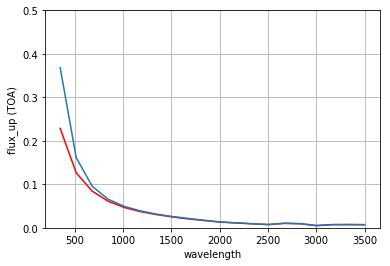

In [26]:
m['flux_down (0+)'].sub()[0,:].plot(fmt='r')
m['flux_up (TOA)'].sub()[1,:].plot(vmin=0, vmax=0.5)

In [ ]:
m.describe()